### Process the real (raw) Merian data
1. Scale the image to `ZP = 27.0` (same as HSC).
2. Subtract background. **TODO: Have to consider the effect of background subtraction and image scaling on the weight map.**
3. Extract PSF at a given position
    
    Download and install `psfex`: https://github.com/esheldon/psfex

    Documentation: https://psfex.readthedocs.io/en/latest/GettingStarted.html

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, hstack, vstack, QTable
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache

import kuaizi
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.download import download_decals_cutout
from kuaizi import DECaLS_pixel_scale, DECaLS_zeropoint

import pickle
from IPython.display import clear_output

In [3]:
import sep
from kuaizi.utils import save_to_fits
import os
import sys

In [4]:
kuaizi.set_env(project='Merian', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

'/scratch/gpfs/jiaxuanl/Data/Merian/'

In [67]:
obj_cat = Table.read('./Catalogs/t9813_deep_native/hsc_merian_joint_native_pts.fits')

In [68]:
obj_cat.sort('hsc_index')

obj_cat['half_size'] = np.ones(len(obj_cat)) * 10 * u.arcsec
obj_cat.rename_column('coord_ra', 'ra')
obj_cat.rename_column('coord_dec', 'dec')
obj_cat.rename_column('hsc_index', 'ID')
obj_cat['name'] = obj_cat['ID']

obj_cat[:500].write('./Cutout/stars/stars_obj_cat_joint_native.fits', overwrite=True)

In [63]:
hdu = fits.open('./Cutout/stars/1/1832/168/stars_1832_N708_deepCoadd_calexp.fits')
print(hdu[1].data.shape)

(119, 119)


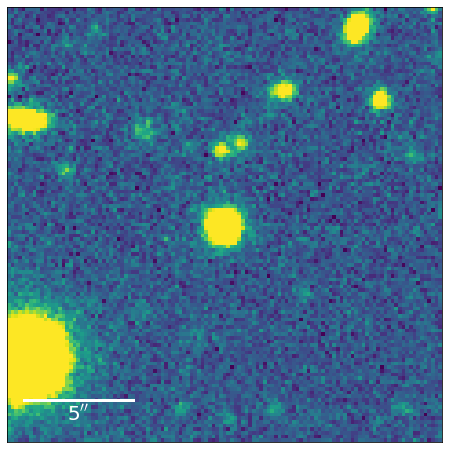

In [64]:
display_single(hdu[1].data);

(119, 119)


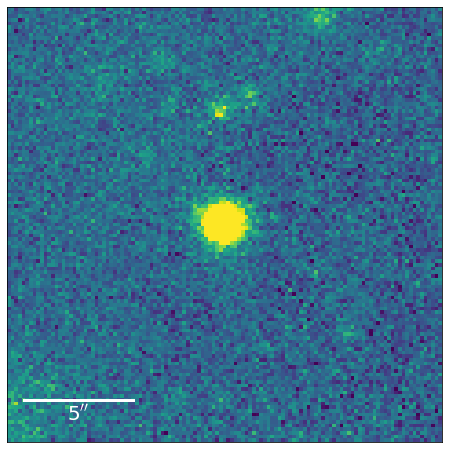

In [65]:
hdu = fits.open('./Cutout/stars/1/1832/stars_1832_g_deepCoadd_calexp.fits')
print(hdu[1].data.shape)
display_single(hdu[1].data);

(77, 77)


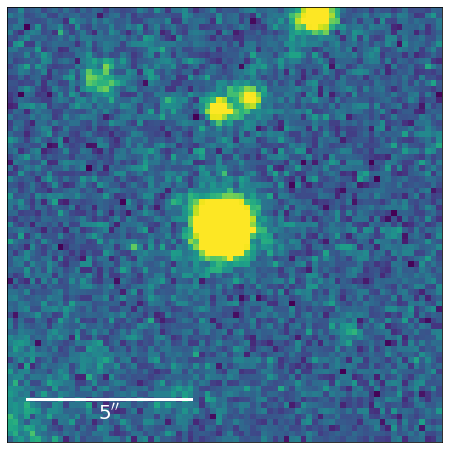

In [66]:
hdu = fits.open('./Cutout/stars/1/1832/stars_1832_N708_deepCoadd_calexp.fits')
print(hdu[1].data.shape)
display_single(hdu[1].data);

---

### First generate N708/N540 using `merian_batch_cutout.py`. Please `ssh tiger2-sumire`.

### Also generate HSC cutout using `merian_batch_cutout_hsc.py`.

In [10]:
obj_cat = Table.read('/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/stars/stars-2022-05-28.fits')
# obj_cat.remove_column('prefix')
# obj_cat.write('./Cutout/stars/stars-2022-05-28_test.fits', overwrite=True)

In [8]:
obj_cat

name,dir,chunk,ra,dec,half_size
,,,,,arcsec
int64,bytes57,int64,float64,float64,float64
1832,/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/stars/1/1832,1,150.57554178560906,1.5358103525310651,10.0
2434,/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/stars/1/2434,1,150.5977313187183,1.5525960498245008,10.0
2748,/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/stars/1/2748,1,150.57399042963755,1.5567145951470487,10.0
4699,/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/stars/1/4699,1,150.40380380129065,1.49689354484757,10.0
5001,/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/stars/1/5001,1,150.426597888368,1.5046642515908644,10.0
5822,/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/stars/1/5822,1,150.49456462822224,1.5146563642355966,10.0
6013,/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/stars/2/6013,2,150.4575937127335,1.5126010410439896,10.0
6478,/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/stars/2/6478,2,150.35294495348842,1.5206949177759064,10.0


### Also need to generate HSC cutouts

In [37]:
sys.path.append('/home/jiaxuanl/Research/Merian/merian_tractor/scripts')
from s18a_batch_cutout import batch_cutout

In [24]:
DATADIR="/scratch/gpfs/jiaxuanl/Data/"
LSBGDIR="/scratch/gpfs/jiaxuanl/Data/Merian/"

In [30]:
batch_cutout(DATADIR, 
             LSBGDIR + "/Cutout/stars/stars-2022-04-25_n708_test.fits", 
             catalog_dir='./Catalogs/stars/',
             low=0, high=None, size='half_size', unit='arcsec', 
             bands='grizy', name='name', prefix='s18a_wide', njobs=3,
             overwrite=False)


 Number of jobs: 3

 Number of galaxies: 2
    - Generate cutouts for 2 galaxies in g-band.
    - Generate cutouts for 2 galaxies in r-band.
    - Generate cutouts for 2 galaxies in i-band.
    - Generate cutouts for 2 galaxies in z-band.
    - Generate cutouts for 2 galaxies in y-band.
Elapsed time: 63.74 s


In [150]:
obj['prefix'].replace('./Cutout/', './Cutout/' +
                        obj['dir'].replace(
                            '/scratch/gpfs/jiaxuanl/Data/Merian/Cutout/', '') + '/')

'./Cutout/magellan_spec/1/296216/s18a_wide_296216'

In [64]:
obj

NameError: name 'obj' is not defined